<a href="https://colab.research.google.com/github/wrightky/ANUGA_OnionCreek_Tutorial/blob/main/notebooks/notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<div align="center">**Lab 4: 2D unsteady modeling with ANUGA**</div>
##<div align="center">CE 377K - River Mechanics</div>
###<div align="center">March 29-31, 2022</div>

## Information on this lab:

**Goal:** Introduce some of the basics of 2D flood modeling using the **ANUGA** hydrodynamic model. This model solves the 2D shallow-water equations on an unstructured triangular grid.

**Software:** ANUGA, Python, Jupyter Notebooks, other packages

**Installation:** None, this lab is run on the cloud in the Google `colaboratory` environment.

**Details:** In this tutorial, we will build a simple, small, coarse model of the **Onion Creek Watershed**. Different cell blocks will demonstate how one can build the model mesh, initialize the domain, setup the parameters of the model, and run the simulation. 

The point of this script is not to build the best model we can of the domain, but rather to **demonstrate the workflow** of constructing a model that can be modified or replicated for other (better) models. 

These notebooks are written in Python 3, and have been designed to run in the Google `colaboratory` environment, which provides a Jupyter notebook environment running on a virtual machine on the cloud. Nothing needs to be installed locally, as it is entirely run on Google Drive. All you need is a Google account. All of these scripts are stored on GitHub, which is a platform for sharing open-source codes.

To start interacting with the notebook, make sure it is open in Colab (see `Open in Colab` link above). Once you're there, click `File` > `Save a Copy in Drive`.

## Setup Environment

The first thing we have to do is set up our environment. In Python, this means downloading all the necessary functions we want to use, including ANUGA.

Run the following cell to install the dependencies and some extra code for visualising on Colaboratory. To run each code block, you can simply type `shift` + `enter`

Wait until you see the comment *(5) Ready to go* before proceeding to subsequent commands. The install should take less than a minute.

NOTE: Tutorial installation is based on the [2018 CSDMS Anuga Clinic](https://github.com/stoiver/anuga-clinic-2018)

In [1]:
# Here we download/install all the files we need behind the scenes
try:
    import os
    os.chdir('/content')
    # Grab workbook files into colab directory
    !git clone https://github.com/wrightky/ANUGA_OnionCreek_Tutorial.git
    # Install everything using some bash scripts
    !/bin/bash /content/ANUGA_OnionCreek_Tutorial/anuga_tools/install_anuga_colab.sh
    !python /content/ANUGA_OnionCreek_Tutorial/anuga_tools/install.py > /dev/null 2>&1 
    !cp ANUGA_OnionCreek_Tutorial/anuga_tools/shallow_water_domain.py anuga_core/anuga/shallow_water/
except:
    pass

# Deal with some directory stuff
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
import sys
sys.path.append(os.path.join(workbookDir,"ANUGA_OnionCreek_Tutorial"))
sys.path.append(os.path.join(workbookDir,"anuga_core"))

Cloning into 'ANUGA_OnionCreek_Tutorial'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 86 (delta 34), reused 65 (delta 18), pack-reused 0
Unpacking objects: 100% (86/86), done.
(1) Install pip packages
(2) Install gdal
(3) Install netcdf4
(4) Download anuga_core github repository
(5) Install anuga
(6) Ready to go


Now that everything is installed, we can load the packages we want to use directly into this notebook. Most of these are very common packages, and each one contains a different group of functions that are useful for scientific applications. We access these functions by 'importing' the packages we need. See the comments below for a brief discription of what each of these packages are for.

In [2]:
import numpy as np # Array manipulation, most important Python package
import matplotlib # Plotting/visualization
import matplotlib.pyplot as plt # Convenient shorthand for the main plotting function
matplotlib.use('Agg') # Settings
%matplotlib inline
from scipy.interpolate import interp1d # Simple linear interpolation
import pandas as pd # Spreadsheets/excel data
import os # Operating system, handles directories
# from google.colab import files # Also for files
import glob # Also for files
from PIL import Image # For making output animations
import anuga # The model itself
from anuga.utilities import animate # Built-in plotting tool for the model
from anuga import Inlet_operator # Explained later

## Create ANUGA domain and mesh

Now we can begin constructing our model domain. This means we need to create a mesh, add any initial and boundary conditions, and handle any settings.

First, we need to specify our model geometry. In the following cell, we specify the coordinates of the boundary polygon for our model, and **instantiate the model domain and mesh** from that polygon. The internal mesh engine does almost all of the work for us here, we just need to feed it our **domain size**, desired **mesh resolution**, and any **interior polygons** we might want (if we have any). 

Interior polygons are one of the powerful features of ANUGA. We can have any number of regions inside our domain with their own mesh resolution. Is there an area you really care about and want to model in high-resolution? Easy. Is there an area you need to include but don't care a lot about, and can make very coarse to save computational time? Also easy. The main constraint is that the polygons defining the boundary of those regions can't overlap.

For visualization, we will be making use of ANUGA's `animate.Domain_plotter` tool, which we initialize here and call repeatedly later.

*Note: Always make sure units are in metric, ANUGA does not support customary units*

Default false northing is 10000000.000000.
ANUGA does not correct for differences in False Northings.
Figure files for each frame will be stored in _plot
------------------------------------------------
Mesh statistics:
  Number of triangles = 17751
  Extent [m]:
    x in [6.22338e+05, 6.26983e+05]
    y in [3.33853e+06, 3.34113e+06]
  Areas [m^2]:
    A in [2.02307e+02, 6.24931e+02]
    number of distinct areas: 17751
    Histogram:
      [2.02307e+02, 2.44569e+02[: 92
      [2.44569e+02, 2.86832e+02[: 1305
      [2.86832e+02, 3.29094e+02[: 2893
      [3.29094e+02, 3.71357e+02[: 3191
      [3.71357e+02, 4.13619e+02[: 2749
      [4.13619e+02, 4.55881e+02[: 2364
      [4.55881e+02, 4.98144e+02[: 1904
      [4.98144e+02, 5.40406e+02[: 1559
      [5.40406e+02, 5.82668e+02[: 1056
      [5.82668e+02, 6.24931e+02]: 638
    Percentiles (10 percent):
      1775 triangles in [2.02307e+02, 2.93950e+02]
      1775 triangles in [2.93950e+02, 3.19167e+02]
      1775 triangles in [3.19167e+02, 3.426

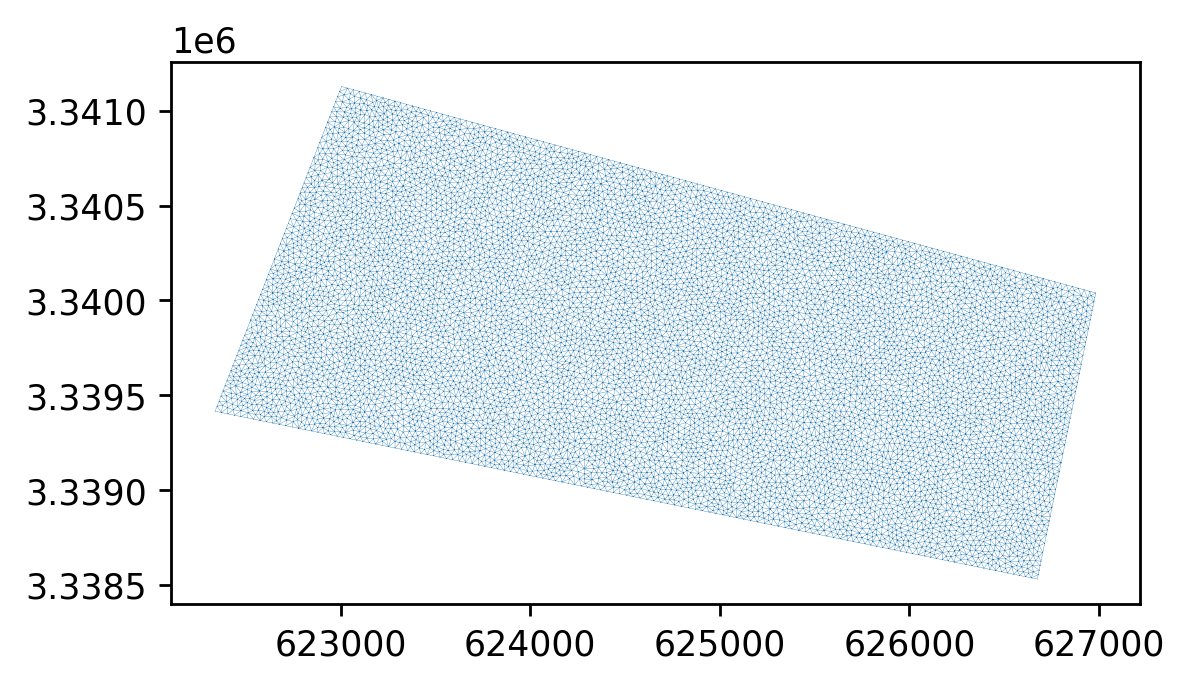

In [4]:
# ---------------Define Domain Boundary-----------------
bounding_polygon = [[622338.0, 3339415.0], [623005.0, 3341128.0],
                    [626983.0, 3340039.0], [626675.0, 3338530.0]]

# Assign a name to the different kinds of boundaries, needed for BCs later
boundary_tags={'sides': [0,1,3], 'downstream': [2]} # ID of segments, not points

# ---------------Define Geo Reference-------------------
geo_reference = anuga.Geo_reference(zone=14,
                                    datum='wgs84',
                                    projection='UTM',
                                    false_easting=500000,
                                    false_northing=0)

# Mesh Resolution (max area of triangles in each given region)
base_res = 625. # Ensures that all cells have less area than this max value

# ---------------Generate domain and mesh---------------
domain = anuga.create_domain_from_regions(bounding_polygon, boundary_tags,
                                          maximum_triangle_area=base_res,
                                          mesh_geo_reference=geo_reference,
                                          mesh_filename='onion.msh')

# Plot mesh
fig = plt.figure(figsize=(5, 5), dpi=250, facecolor='w', edgecolor='k')
dplotter = animate.Domain_plotter(domain)
plt.triplot(dplotter.triang, linewidth=0.1);
plt.axis('scaled')

# Print out some descriptive statistics of our mesh cells
print(domain.statistics())

The previous cell should print out some statistics of your mesh, as well as a picture of it. Note the "Number of triangles". How does this value change if you modify the `base_res` (mesh resolution)?

After this cell, our model `domain` now exists, and we can begin populating it with information about our study site.

## Create bathymetry/topography

Now that we have a mesh, we need to provide **elevation** values for each of those cells. We do this using a **topographic DEM** stored in an ASCII file. This is the same DEM used in Lab 3, just converted into a different format and metric units. Because ANUGA requires DEMs to be stored in certain data-types, here we convert this data a couple times until it's in a format ANUGA can use (`.dem`, `.pts`). Finally, we use the resulting `.pts` file to create our model bathymetry.

These steps can be **quite slow** for high-resolution meshes, so if the mesh isn't changing between runs, we recommend **saving the resulting topography** from the domain as a `.csv` and just re-loading that file for future runs. This file will be a long list of elevation values sorted by triangle ID.

*Note: The ASCII file needs to have the same headers as the file used here, which sometimes isn't the default. To repeat these steps, check the ASCII file with a text editor and make sure it has the same headers as the example ASCII files in th ANUGA examples folder. It also needs the accompanying `.prj` file!*

Reading METADATA from ANUGA_OnionCreek_Tutorial/data/EG_OnionCreek_2m_EPSG_32614_m.prj
Reading DEM from ANUGA_OnionCreek_Tutorial/data/EG_OnionCreek_2m_EPSG_32614_m.asc
Got 1579 lines
Store to NetCDF file ANUGA_OnionCreek_Tutorial/data/EG_OnionCreek_2m_EPSG_32614_m.dem
Reading DEM from ANUGA_OnionCreek_Tutorial/data/EG_OnionCreek_2m_EPSG_32614_m.dem
Store to NetCDF file ANUGA_OnionCreek_Tutorial/data/EG_OnionCreek_2m_EPSG_32614_m.pts
There are 4297436 values in the elevation
There are 4297436 values in the clipped elevation
There are 1458362 NODATA_values in the clipped elevation
FitInterpolate: Building quad tree
Building smoothing matrix
Fit.fit: Initializing
Geospatial_data: Created from file: ANUGA_OnionCreek_Tutorial/data/EG_OnionCreek_2m_EPSG_32614_m.pts
Data will be loaded blockwise on demand
Got 1 variables: ['elevation']
Default false northing is 10000000.000000.
ANUGA does not correct for differences in False Northings.
Default units is m.
ANUGA does not correct for differenc

(622105.75, 627215.25, 3338400.1, 3341257.900000001)

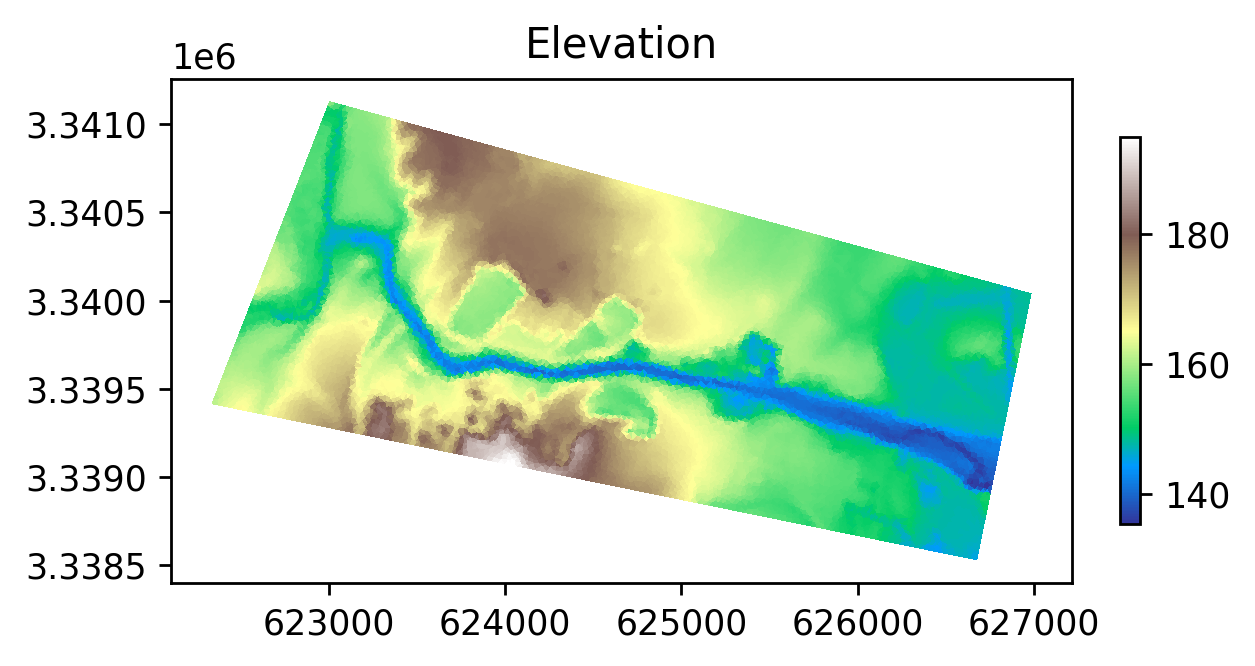

In [5]:
# ASCII to DEM conversion
anuga.asc2dem('ANUGA_OnionCreek_Tutorial/data/EG_OnionCreek_2m_EPSG_32614_m.asc',
              use_cache=False, verbose=True)
# DEM to "points"
anuga.dem2pts('ANUGA_OnionCreek_Tutorial/data/EG_OnionCreek_2m_EPSG_32614_m.dem',
              use_cache=False, verbose=True)
# Use "points" to populate mesh cells
domain.set_quantity('elevation', 
                    filename='ANUGA_OnionCreek_Tutorial/data/EG_OnionCreek_2m_EPSG_32614_m.pts',
                    use_cache=False, verbose=True, alpha=0.1)

# Plot topography
fig=plt.figure(figsize=(5, 5), dpi= 250, facecolor='w', edgecolor='k')
plt.tripcolor(dplotter.triang, facecolors = dplotter.elev, cmap = 'terrain')
plt.colorbar(fraction=0.02);
plt.title("Elevation");
plt.axis('scaled')

# To save time next time, we can save the result
# topo = domain.quantities['elevation'].centroid_values
# np.savetxt('ANUGA_OnionCreek_Tutorial/data/EG_OnionCreek_2m_EPSG_32614_m.csv', topo, delimiter=",")

## Add boundary conditions

Now we use some nearby USGS gauge data to prescribe our model **boundary conditions**. Here we use two common types of BCs: **Dirichlet** and **Reflective**. For the former, we tell the model exactly what the water surface elevation and/or velocities are along that boundary as a function of time. For the latter, the boundary acts like a solid wall, bouncing any flows back inside the domain. 

We assign our downstream boundary condition to match the water surface elevations of the nearby gauge using ANUGA's `Time_boundary` function. ANUGA has **three conserved quantities** that we have to specify: [`stage`, `xmomentum`, `ymomentum`]. `stage` is the water surface elevation ($\eta = z + h$), and `momentum` $q = [uh, vh]$. We use the gauge data to specify these along the downstream BC as a function of time (only `stage` is set to vary here). All the other boundaries are designated as a no-flux `Reflective_boundary`, because we don't expect flows in those directions.

*Note: Due to **poor boundary placement** in relation to where these gauges are located, we've added a few fudge factors in the following sections for the purposes of this demonstration. Ideally, your boundaries should be drawn where you have a good sense for the **mass balance** of your system!*

In [7]:
# Load gauge data into a Pandas "DataFrame"
usgs_a = pd.read_csv('ANUGA_OnionCreek_Tutorial/data/USGS_Onion183_metric.csv',
                     header=0, names=['ID','datetime','tz','Q','WL'])
usgs_a['datetime'] = pd.to_datetime(usgs_a['datetime']) # Convert to datetime dtype
# Need to convert datetimes into 'seconds from initial time'
usgs_a['epoch'] = (usgs_a['datetime'] - usgs_a['datetime'][0]) // pd.Timedelta("1s")

usgs_b = pd.read_csv('ANUGA_OnionCreek_Tutorial/data/USGS_Williamson_metric.csv',
                     header=0, names=['ID','datetime','tz','Q','WL'])
usgs_b['datetime'] = pd.to_datetime(usgs_b['datetime']) # Convert to datetime dtype
# Need to convert datetimes into 'seconds from initial time'
usgs_b['epoch'] = (usgs_b['datetime'] - usgs_b['datetime'][0]) // pd.Timedelta("1s")

# Print out one of these DataFrames to get a sense for what it looks like:
usgs_a # This will print out a snippet. Looks like a spreadsheet!

,ID,datetime,tz,Q,WL,epoch
0,8159000,2022-03-21 17:00:00,CDT,0.351129,136.524000,0
1,8159000,2022-03-21 17:05:00,CDT,0.342634,136.520952,300
2,8159000,2022-03-21 17:10:00,CDT,0.351129,136.524000,600
3,8159000,2022-03-21 17:15:00,CDT,0.351129,136.524000,900
4,8159000,2022-03-21 17:20:00,CDT,0.351129,136.524000,1200
...,...,...,...,...,...,...
840,8159000,2022-03-24 15:00:00,CDT,1.211961,136.725168,252000
841,8159000,2022-03-24 15:05:00,CDT,1.211961,136.725168,252300
842,8159000,2022-03-24 15:10:00,CDT,1.211961,136.725168,252600
843,8159000,2022-03-24 15:15:00,CDT,1.189308,136.722120,252900


Now we have loaded in the data from two USGS gauges. Gauge "A" is [08159000 on Onion Creek at 183](https://waterdata.usgs.gov/nwis/uv/?site_no=08159000&agency_cd=USGS) and gauge B is [08158970 on Williamson Creek](https://waterdata.usgs.gov/nwis/uv/?site_no=08158970&agency_cd=USGS). Technically Gauge A is in the middle of our domain, but for this demonstration we're going to use it to define an inflow.

The two datasets correspond to the storm that came through on March 21st 2022, which is the time period we're going to be modeling. The downloaded files span from 5PM on March 21st through March 24th, and all values have been converted to $[m]$ or $[m^3/s]$

Let's use the water level information from Gauge A to specify the `stage` for our downstream boundary, by creating a function that interpolates this `DataFrame` as a function of time:

In [8]:
vert_offset = 1.0 # Fudge factor, vertical correction to gauge data
# Create a linear interpolation function for the WSE:
fBC_downstream = interp1d(usgs_a['epoch'], usgs_a['WL'] + vert_offset, kind='linear')

# Downstream boundary
Bout = anuga.Time_boundary(domain, function=lambda t: [fBC_downstream(t), 0.0, 0.0])

# All other boundaries
Br = anuga.Reflective_boundary(domain)

# Assign BCs to the boundaries we named earlier
domain.set_boundary({'downstream': Bout, 'sides': Br})

## Add discharge hydrograph

Now we add inflows of **discharge** from each of the two upstream channels. We do this by creating an **inlet** through which that discharge is added to the model.

The way ANUGA handles discharge is somewhat odd compared to other models. Most models define a mass inflow as a boundary condition, and every time-step mass is added appropriately. Due to some weird quirks about how ANUGA's numerical solver handles BCs, it works better to add an **inlet** *inside the domain* through which water flows into our domain, somewhat like a flooding bath drain. (Note that **outlets** can be created the same way by specifying a **negative discharge**)

To make a static inlet with a steady discharge value, you add the inlet once and be done with it. Because we want our discharge to vary, we have to update the discharge later inside the loop when we run the model. We do this by modifying the `Q` attribute via `each_inlet.Q = new_value`, as you'll see later.

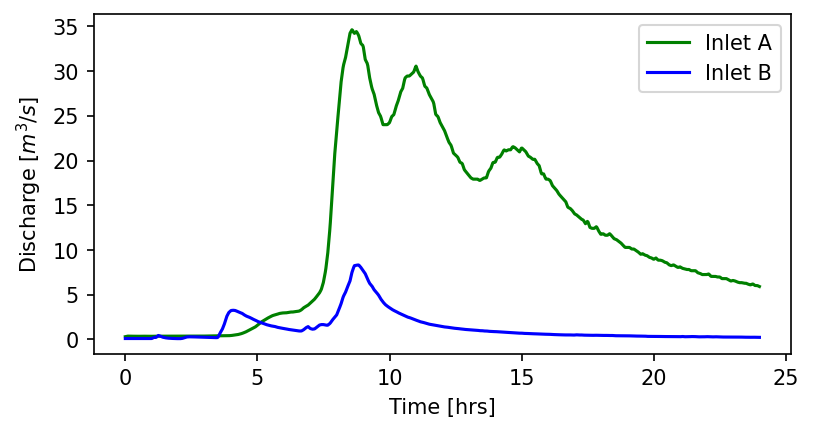

In [9]:
# Create two more linear interpolation functions for Q
# Fudge factor, changing timing & magnitude of gauge A to make up for poor BC placement
usgs_a['epoch_2'] = (usgs_a['datetime'] - usgs_a['datetime'][0] - pd.Timedelta('70 min')) // pd.Timedelta("1s") # Moves up flood arrival by 70 min
fQ_a = interp1d(usgs_a['epoch_2'], usgs_a['Q']*0.8, kind='linear') # Scales down Q by 20%
fQ_b = interp1d(usgs_b['epoch'], usgs_b['Q'], kind='linear')

# Setup inlets (supply coordinates + add "Inlet_operator")
first_inlet = np.array([[622627.,3339957.],[622627.,3339982.]]).astype('double') # Coordinates of line
first_inflow = Inlet_operator(domain, first_inlet, Q = fQ_a(0))

second_inlet = np.array([[623031,3341074],[623035,3341085]]).astype('double') # Coordinates of line
second_inflow = Inlet_operator(domain, second_inlet, Q = fQ_b(0))
# If these Q's were static, we would already be done

# Visualize time-varying Q
tt = np.linspace(0., 86400, 1000) # Vector of time values for plotting
Qplta = [fQ_a(ti) for ti in tt] # Vector of Q values for each tt
Qpltb = [fQ_b(ti) for ti in tt] # Vector of Q values for each tt
plt.figure(figsize=(6,3), dpi=150)
plt.plot(tt/3600., Qplta, 'g-')
plt.plot(tt/3600., Qpltb, 'b-')
plt.xlabel('Time [hrs]')
plt.ylabel('Discharge [$m^3/s$]')
plt.legend(['Inlet A','Inlet B'])

Now our domain will have inflows when we run the code. The `Inlet_operator` that we used above is an optional add-on function that tells ANUGA, in plain language, "*there is an inlet here with this amount of discharge*". "Operator" is a generic term for lots of optional add-ons in ANUGA that can modify the model in some way. The location of our inlet is just a simple line, and all the cells that intersect that line will act as our inlet. 

## Add rainfall

We can also add rainfall to our model, which adds water to all our model cells at some specified rate (mm/s) over a specified period of time. 

For this simulation, we've simplified the real hyetograph into two windows of rainfall, based on nearby City of Austin estimates. There were roughly two periods of rainfall on March 21st: window 1 was around 6PM, and window 2 was around midnight. About 3.2 inches (81.3 mm) fell in total.

Text(0, 0.5, 'Rainfall rate [$mm/s$]')

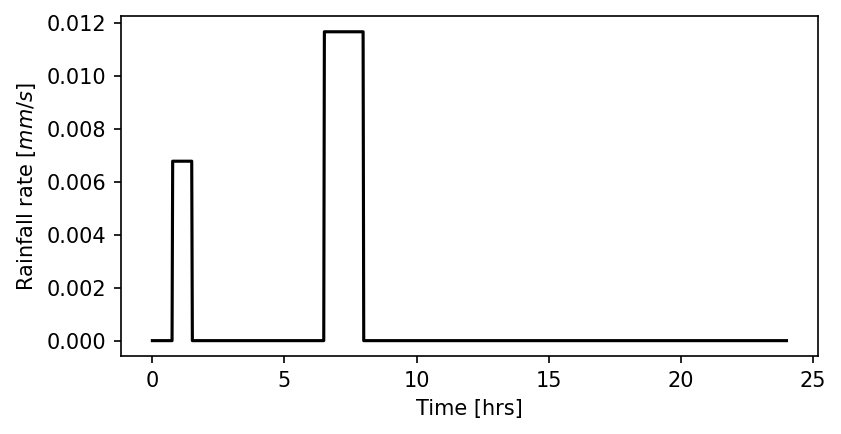

In [10]:
# Details for our simplified hyetograph
window1 = [2700, 5400] # Seconds after model start time (5PM on March 21st)
window2 = [23400, 28800]
rain_rate_window1 = 0.006778 # mm/s
rain_rate_window2 = 0.011667 # mm/s

# Create a function that returns the rainfall rate as a function of time
def rainfall(t):
  if window1[0] <= t < window1[1]:
    rate = rain_rate_window1
  elif window2[0] <= t < window2[1]:
    rate = rain_rate_window2
  else:
    rate = 0.
  return rate

# Append to forcing terms; this adds rain to our model domain
R = anuga.Rainfall(domain, rate=rainfall)
domain.forcing_terms.append(R)

# Visualize time-varying R
tt = np.linspace(0., 86400, 1000) # Vector of time values for plotting
RR = [rainfall(ti) for ti in tt] # Vector of rainfall values for each tt
plt.figure(figsize=(6,3), dpi=150)
plt.plot(tt/3600., RR, 'k-')
plt.xlabel('Time [hrs]')
plt.ylabel('Rainfall rate [$mm/s$]')

## Initialize Stage

Now we tie up a few loose ends. We need to specify the **stage** initial condition, which we set to equal the height at the downstream boundary anywhere where the elevation is lower than that value (and dry everywhere else). We can do this using `set_quantity()`, which we could have used to initialize any of our variables if we wanted to (e.g. momentum)

In [11]:
# ---------------Load pre-established elevation----------------------
topo = domain.quantities['elevation'].centroid_values
stage = topo.copy()  # Initialize stage as = topography
# Is elevation is lower than WSE downstream, set stage = WSE
stage[topo <= fBC_downstream(0)] = fBC_downstream(0)
domain.set_quantity('stage', stage, location='centroids')  # Initialize depth

## Initialize Friction

Finally, we apply a uniform Manning's coefficient $n=0.05$ everywhere in the domain. Note that this value can vary spatially, we're just using one value for simplicity.

In [12]:
# Create empty vector of 1's with the same dimensions as topo, multiply by n
friction = np.ones_like(topo)*0.05
domain.set_quantity('friction', friction, location = 'centroids')

## Run the model

Finally, we can run the model!

Here we call on `domain.evolve()` to **run the model** for a specified amount of time. There are two kinds of timesteps to be aware of: the **model timestep** and the **yieldstep**. In ANUGA, the model timestep is automatically computed based on numerical stability conditions, and is usually some small value $\approx \mathcal{O}(1s)$. However, we can't save the data for every timestep, because output file would be enormous. We therefore specify a yieldstep, which is the time interval (in seconds) at which the model **saves information** on the model's converved quantities (`stage`, `xmomentum`, `ymomentum`) into the output file. We use the command `domain.print_timestepping_statistics()` to tell us some summary statistics of these timesteps every `yieldstep`.

As the model runs, output data are saved into a NetCDF file with the extension `.sww`. This is a common and efficient data type for storing numeric data, and can be opened by many programs, not just ANUGA. 

The `domain.evolve()` function works like a typical *for* loop: *for t less than final time, evolve the model*. This enables us to **make changes to our model** as time progresses, if we wish. In this example, we update discharge within the evolve loop by modify the Q of our inlets we created earlier. Because we only update once every `savefreq`, we use the time value _centered_ in each time window between this yieldstep and the next (i.e. `t + savefreq`). Notice that we do not have to modify the BC or rainfall forcings here -- those were defined using functions of time, so they are automatically updated every time-step. 

In [13]:
# ------------------------------------------------------------------------------
# Evolve system through time
# ------------------------------------------------------------------------------
savefreq = 900. # Yieldstep, in seconds
simtime = 86400. # Total simulation time, in seconds

for n, t in enumerate(domain.evolve(yieldstep=savefreq, finaltime=simtime)):
    # Print out some statistics on the model evolution
    domain.print_timestepping_statistics()

    # -------------Rewrite discharge for current yield step---------------
    first_inflow.Q = fQ_a(t+savefreq)
    second_inflow.Q = fQ_b(t+savefreq)

Time = 0.0000 (sec), steps=0 (507s)
Time = 900.0000 (sec), delta t in [1.56805691, 1.56903429] (s), steps=574 (4s)
Time = 1800.0000 (sec), delta t in [1.56806236, 1.56806406] (s), steps=574 (4s)
Time = 2700.0000 (sec), delta t in [1.56806240, 1.56806240] (s), steps=574 (4s)
Time = 3600.0000 (sec), delta t in [1.20621341, 1.56806240] (s), steps=575 (17s)
Time = 4500.0000 (sec), delta t in [1.55450922, 1.56734987] (s), steps=576 (10s)
Time = 5400.0000 (sec), delta t in [1.55248103, 1.55449043] (s), steps=580 (8s)
Time = 6300.0000 (sec), delta t in [1.47501782, 1.55639633] (s), steps=588 (8s)
Time = 7200.0000 (sec), delta t in [1.40466830, 1.47489441] (s), steps=628 (8s)
Time = 8100.0000 (sec), delta t in [1.37436527, 1.40462191] (s), steps=649 (8s)
Time = 9000.0000 (sec), delta t in [1.34427688, 1.37435459] (s), steps=663 (8s)
Time = 9900.0000 (sec), delta t in [1.32114476, 1.34426730] (s), steps=676 (9s)
Time = 10800.0000 (sec), delta t in [1.30555686, 1.32112533] (s), steps=686 (9s)
Ti

As the model evolves, you should see timestepping statistics printed out every yieldstep. Here's the meaning for those numbers:
- The first value is the "real" amount of time that has been modeled so far.
- "delta t" is the range of model timesteps taken during that yieldstep.
- "steps" is the number of model timesteps taken in that yieldstep.
- The number in the parentheses at the end is the amount of clock time that has elapsed since the last yieldstep, i.e. how long you'll have to wait for the model to finish.

## Inspect outputs

Now that we've run the model, let's view some results!

There are a couple ways one can query the output file. ANUGA's `.sww` files can be loaded using any normal NetCDF reader, but ANUGA also comes pre-packaged with several functions for inspecting your model results, most of which are stored in `anuga.utilities.plot_utils`

In [51]:
# saved_output = 'domain.sww' # Output of current run
saved_output = 'ANUGA_OnionCreek_Tutorial/notebooks/domain.sww' # Pre-saved output

# Load in values of conserved quantities at every cell centroid
swwvals = anuga.utilities.plot_utils.get_centroids(saved_output, timeSlices='all')
# Query values: time, x, y, stage, elev, height, xmom, ymom, xvel, yvel, friction, vel, etc
model_starttime = pd.to_datetime('2022-03-21 17:00:00')
dplotter = animate.SWW_plotter(saved_output) # Update dplotter if necessary

# Separate variables just for accessibility
time = swwvals.time
topo = swwvals.elev
x = swwvals.x
y = swwvals.y
depth = swwvals.height
stage = swwvals.stage
u = swwvals.xvel
v = swwvals.yvel
w = np.sqrt(u**2 + v**2)

Figure files for each frame will be stored in _plot


(622105.75, 627215.25, 3338400.1, 3341257.900000001)

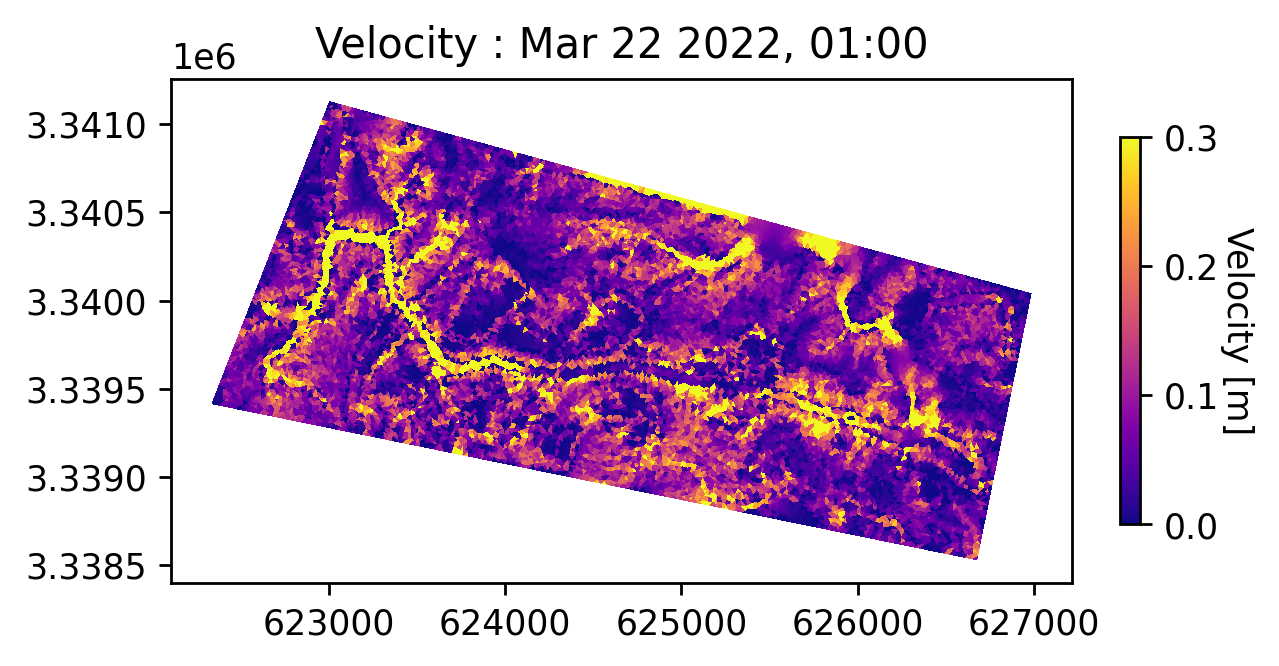

In [52]:
# ------------------------------------------------------------------------------
# Plot a single map of velocity at centroids
# ------------------------------------------------------------------------------
# Time index to plot:
time_idx = 32

timeUTC = pd.to_timedelta(time[time_idx], 's') + model_starttime
fig = plt.figure(figsize=(5, 5), dpi=250, facecolor='w', edgecolor='k')
plt.tripcolor(dplotter.triang, facecolors=w[time_idx,:], 
              vmax=0.3, vmin=0, cmap='plasma')
cbar = plt.colorbar(fraction=0.02);
cbar.set_label('Velocity [m]', rotation=270, labelpad=10)
plt.title('Velocity : '+timeUTC.strftime("%b %d %Y, %H:%M"));
plt.axis('scaled')

(622105.75, 627215.25, 3338400.0999999996, 3341257.9)

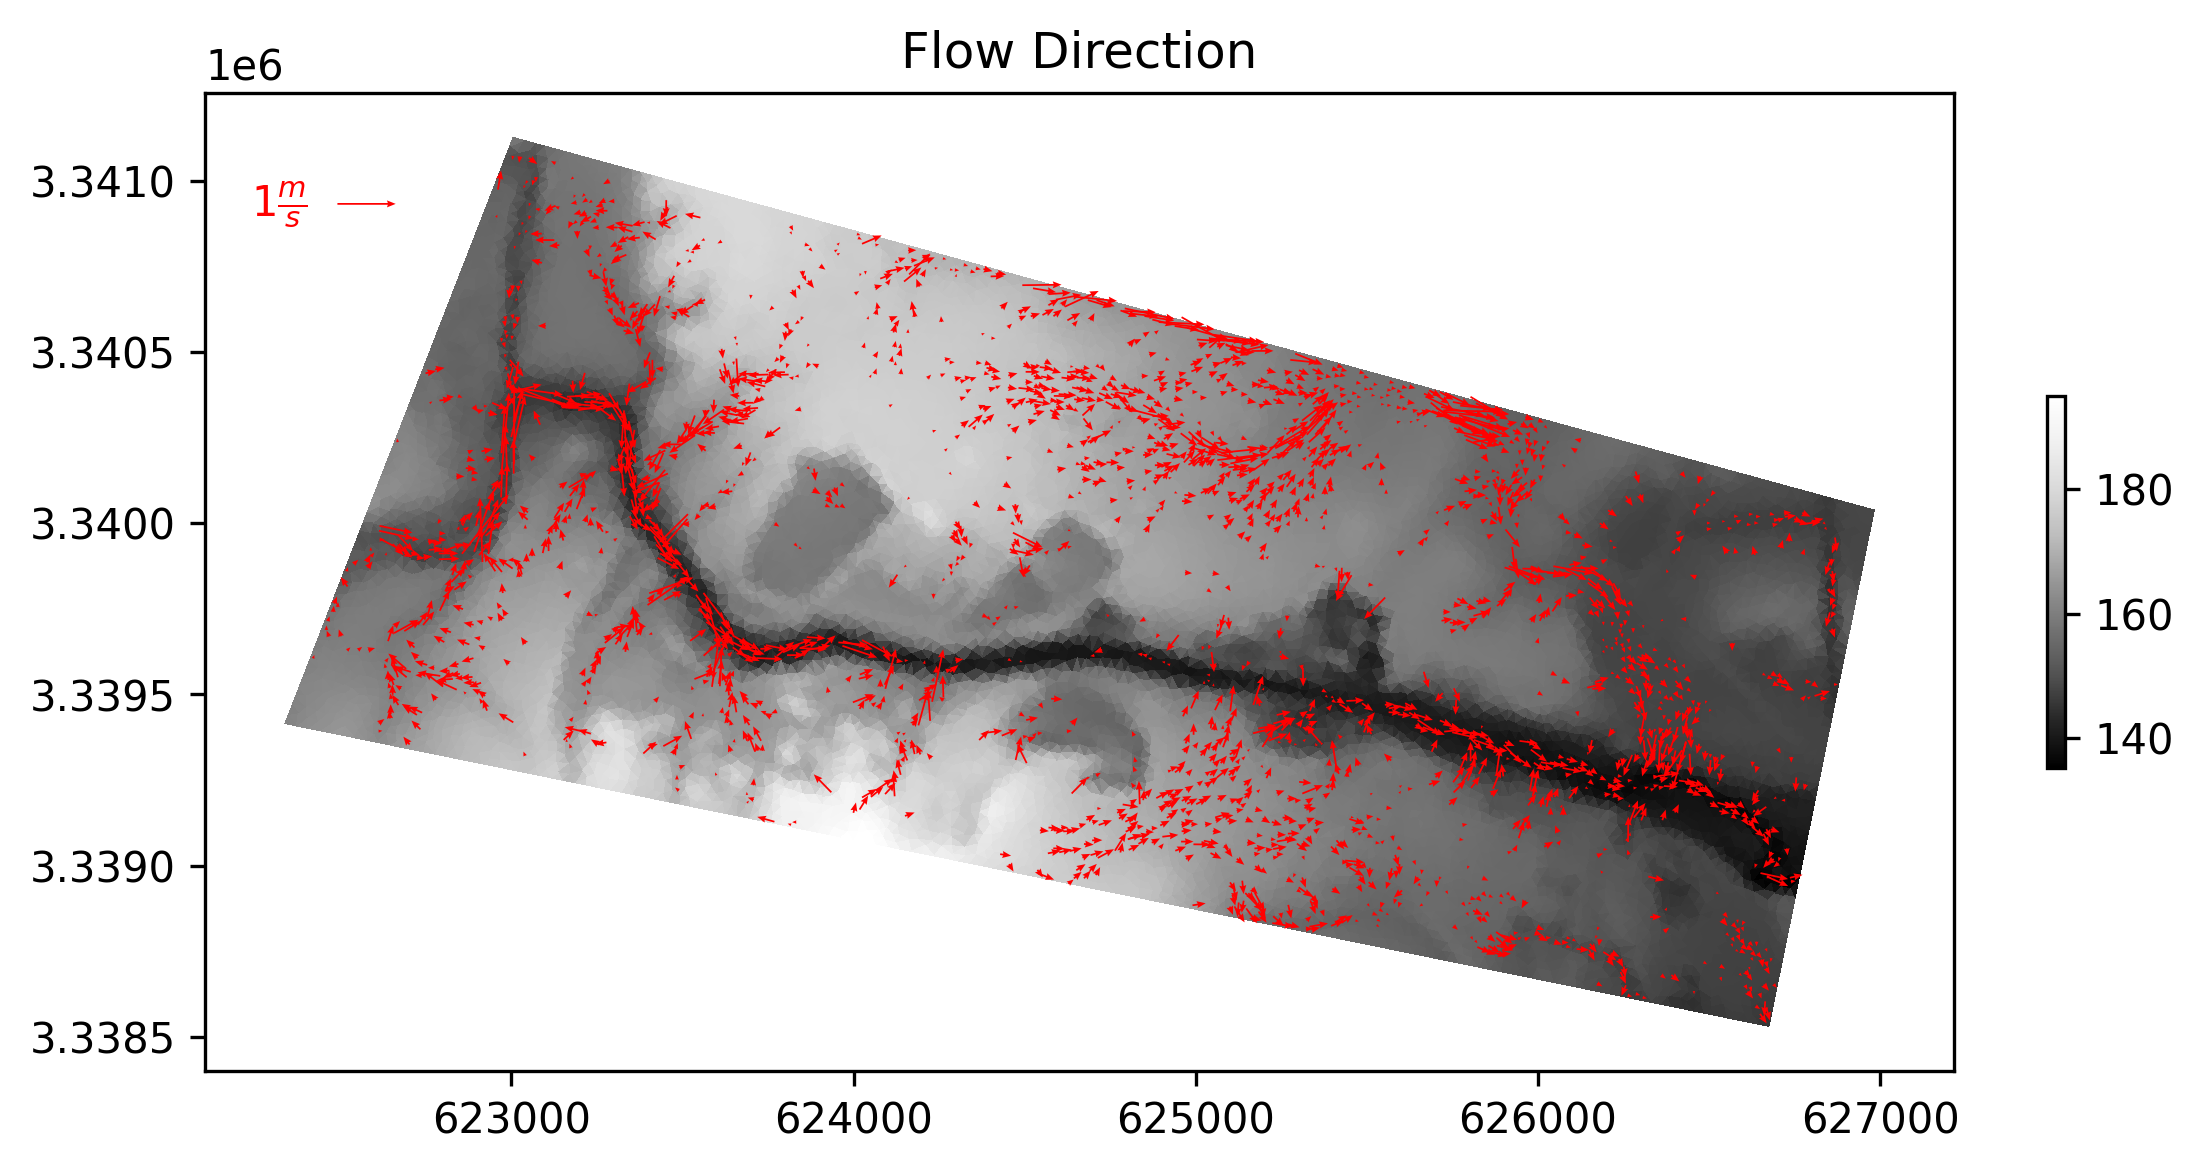

In [53]:
# Time index to plot:
time_idx = 32

# Velocity quiver plot
# Indices of where water is located:
inds = (w[time_idx,:] > 0.05) & (depth[time_idx,:] > 0.01)
inds[0::2] = 0  # Cut it down to half as many arrows
fig = plt.figure(figsize=(8, 8), dpi=300, facecolor='w', edgecolor='k')
plt.tripcolor(dplotter.triang, facecolors=dplotter.elev, cmap='Greys_r')
plt.colorbar(fraction=0.01);
plt.title("Flow Direction")
Quiv = plt.quiver(x[inds], y[inds], u[time_idx,inds], v[time_idx,inds],
                  color='red', scale=30, width=0.001, headwidth=4, pivot='mid')
qk = plt.quiverkey(Quiv, 0.18, 0.66, 1, r'$1 \frac{m}{s}$', labelpos='W',
                   coordinates='figure', labelcolor='red')
plt.axis('scaled')
# plt.savefig(mydir + '/figs/fig_dir' + str(int(t / timestep)) + '.png')
# plt.close()

(622105.75, 627215.25, 3338400.0999999996, 3341257.900000001)

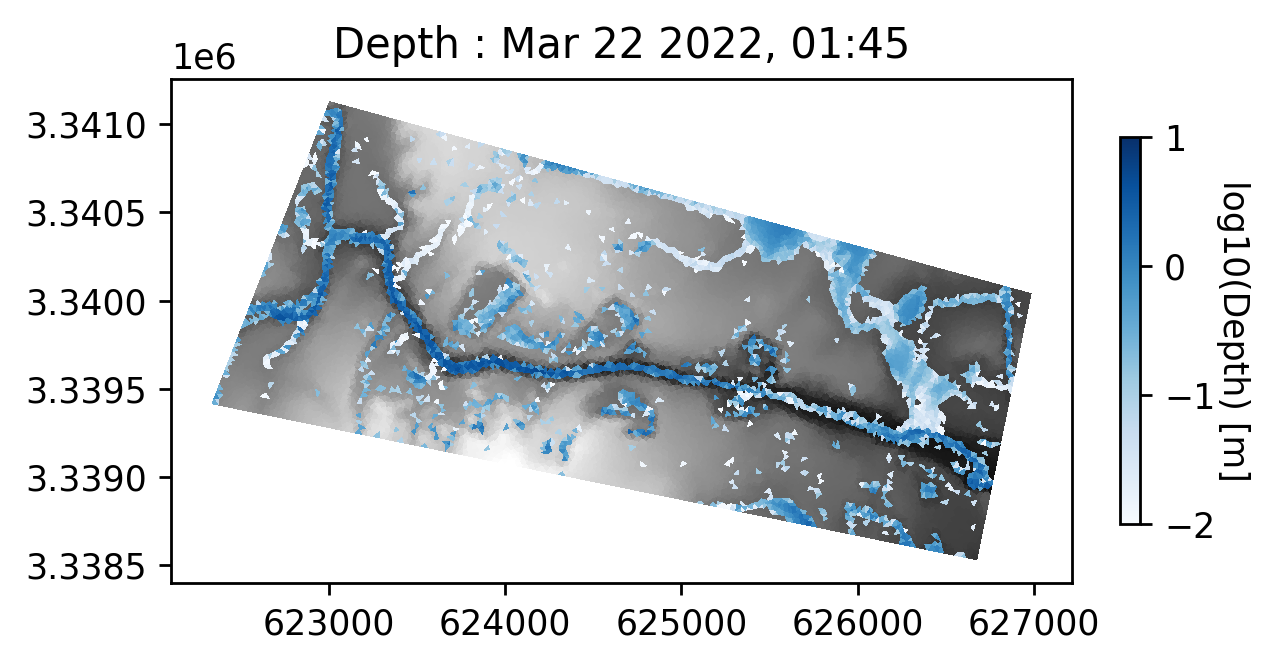

In [58]:
# ------------------------------------------------------------------------------
# Plot a single map of stage at centroids
# ------------------------------------------------------------------------------
# Time index to plot:
time_idx = 35

timeUTC = pd.to_timedelta(time[time_idx], 's') + model_starttime
fig = plt.figure(figsize=(5, 5), dpi=250, facecolor='w', edgecolor='k')
plt.tripcolor(dplotter.triang, facecolors=topo, cmap='Greys_r')
plot_depth = depth[time_idx,:].copy()
plot_depth[plot_depth < 0.01] = np.nan
plt.tripcolor(dplotter.triang, facecolors=np.log10(plot_depth),
              vmin=-2, vmax=1, cmap='Blues')
cbar = plt.colorbar(fraction=0.02);
cbar.set_label('log10(Depth) [m]', rotation=270, labelpad=10)
plt.title('Depth : '+timeUTC.strftime("%b %d %Y, %H:%M"));
plt.axis('scaled')

(622105.75, 627215.25, 3338400.0999999996, 3341257.900000001)

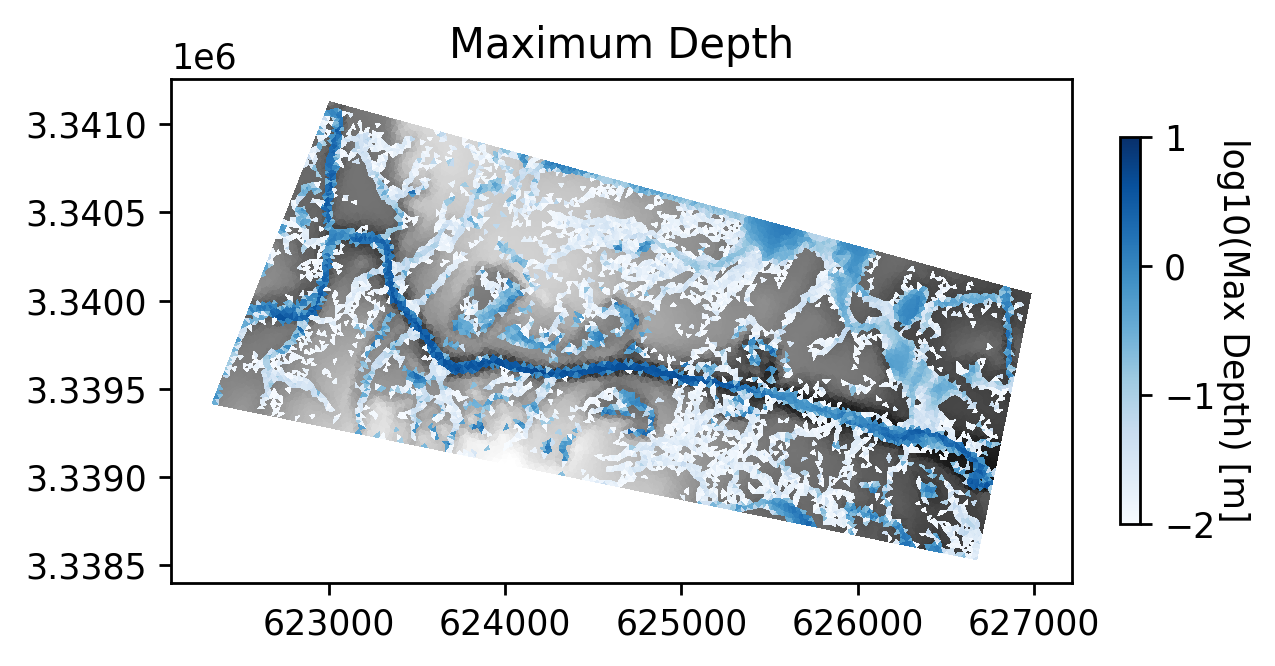

In [59]:
fig = plt.figure(figsize=(5, 5), dpi=250, facecolor='w', edgecolor='k')
plt.tripcolor(dplotter.triang, facecolors=topo, cmap='Greys_r')
plot_depth = np.nanmax(depth, axis=0)
plot_depth[plot_depth < 0.01] = np.nan
plt.tripcolor(dplotter.triang, facecolors=np.log10(plot_depth),
              vmin=-2, vmax=1, cmap='Blues')
cbar = plt.colorbar(fraction=0.02);
cbar.set_label('log10(Max Depth) [m]', rotation=270, labelpad=10)
plt.title('Maximum Depth');
plt.axis('scaled')

Text(0, 0.5, 'Stage [m NAVD88]')

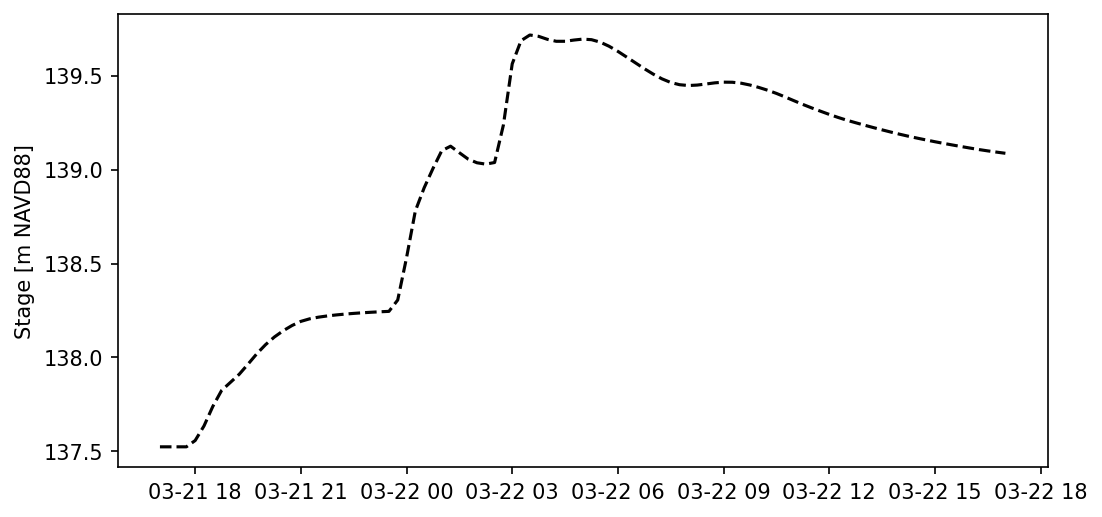

In [64]:
# ------------------------------------------------------------------------------
# Plot time-series at a gauge location
# ------------------------------------------------------------------------------
# Create triangle lookup function to find cell index of a gauge
p = anuga.utilities.plot_utils.get_output(saved_output)
tri_lookup = anuga.utilities.plot_utils.get_triangle_lookup_function(p)

# Create time vector of model outputs
model_timeseries = model_starttime + pd.to_timedelta(time, 's')

# Find coordinates of gauge and cell containing it, extract stage
xx, yy = [626300, 3339250]
idx = tri_lookup(xx, yy)
gaugestage = stage[:, idx]

fig = plt.figure(figsize=(8, 4), dpi=150, facecolor='w', edgecolor='k')
plt.plot(model_timeseries, gaugestage, 'k--')
plt.ylabel('Stage [m NAVD88]')

In [76]:
for time_idx in range(0,len(time)):
  timeUTC = pd.to_timedelta(time[time_idx], 's') + model_starttime
  fig = plt.figure(figsize=(5, 5), dpi=250, facecolor='w', edgecolor='k')
  plt.tripcolor(dplotter.triang, facecolors=w[time_idx,:], 
                vmax=0.3, vmin=0, cmap='plasma')
  cbar = plt.colorbar(fraction=0.02);
  cbar.set_label('Velocity [m]', rotation=270, labelpad=10)
  plt.title('Velocity : '+timeUTC.strftime("%b %d %Y, %H:%M"));
  plt.axis('scaled')
  plt.savefig('velocity_figure_%s.jpg' % time_idx)
  plt.close()

files = glob.glob('velocity_figure_*.jpg')
files = sorted(files, key=os.path.getmtime)
outfile = 'velocity_animation.gif'

# Create GIF
imgs = [Image.open(f).copy() for f in files]
imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:],
              save_all=True, duration=200, loop=0) # Write gif